Working thru this: https://www.geeksforgeeks.org/implementing-recurrent-neural-networks-in-pytorch/

I've left the demo mostly unchanged, but I've generalized it to a forecast window of any length and added a couple comments here and there

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

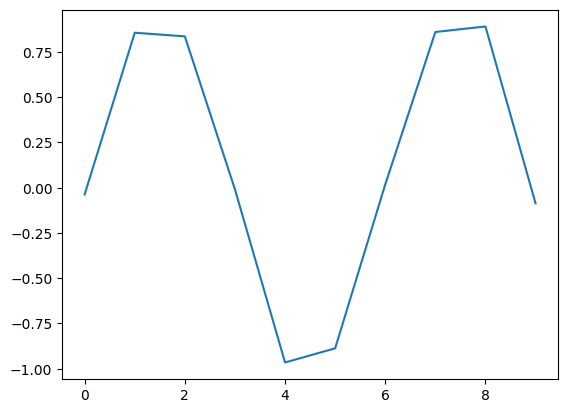

In [2]:
# Generate sine wave data, & I added a bit of noise to training inputs to make it nontrivial
# (otherwise it's just being trained on differences in the sine computation 
# to FLOP errors)
forecast_window = 3
def generate_data(seq_length, num_samples, forecast_window=forecast_window):
    X, y = [], []
    for i in range(num_samples):
        x = np.linspace(i * 2 * np.pi, (i + 1) * 2 * np.pi, seq_length + forecast_window)
        sine_wave = np.sin(2.*x) 
        X.append(sine_wave[:-forecast_window] + 0.03*np.random.normal(size=seq_length))  # input sequence
        y.append(sine_wave[forecast_window:] + 0.03*np.random.normal(size=seq_length))   # target sequence
    return np.array(X), np.array(y)

seq_length = 3 * forecast_window + 1
num_samples = 8
X, y = generate_data(seq_length, num_samples, forecast_window=forecast_window)

# Each row of X, y is a chunk of a sine curve 
# X is the "head" of the curve, and y is the "tail"
# The idea is to have a model that learns predicts y given X

#Plot a sample of the training input just to make sure we're on the right track 
plt.plot(range(seq_length), X[2])
plt.show()

This is what the network should do: having seen a whole bunch of sine waves, when asked to predict the next `forecast_window` values of a sine wave it should work approximately correctly.  

In [3]:
# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print(X.shape, y.shape)  # Output: (1000, 50), (1000, 50)

torch.Size([8, 10]) torch.Size([8, 10])


In [4]:
# Define the RNN
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True) 
        # ^ see the RNN class docs here: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        self.fc = nn.Linear(hidden_dim, output_dim) # needed to make sensible outputs, see Geron's book
    
    def forward(self, x):
        # Note here: it looks like a lot of the actual ANN construction 
        # when using a torch RNN happens in the forward method rather 
        # than in the init (which we saw was A-OK for an FCN)
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

input_dim = 1
hidden_dim = 3 # Even very thin networks give good results
num_layers = 1
output_dim = 1
# NOTE: the input/output dim refer to the dim of the STATE space for the input/outputs: the length of the 
# actual time series/orbits we're using for training do not appear in the definition of the RNN! 
model = SimpleRNN(input_dim, hidden_dim, output_dim, num_layers=num_layers)

In [5]:
# Train
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Training loop
num_epochs = int(2e2)
for epoch in range(num_epochs):
    model.train()
    outputs = model(X.unsqueeze(2))  # Add a dimension for input size
    loss = criterion(outputs, y.unsqueeze(2))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/200], Loss: 0.0923
Epoch [20/200], Loss: 0.0125
Epoch [30/200], Loss: 0.0072
Epoch [40/200], Loss: 0.0046
Epoch [50/200], Loss: 0.0022
Epoch [60/200], Loss: 0.0022
Epoch [70/200], Loss: 0.0017
Epoch [80/200], Loss: 0.0016
Epoch [90/200], Loss: 0.0016
Epoch [100/200], Loss: 0.0015
Epoch [110/200], Loss: 0.0015
Epoch [120/200], Loss: 0.0015
Epoch [130/200], Loss: 0.0015
Epoch [140/200], Loss: 0.0015
Epoch [150/200], Loss: 0.0015
Epoch [160/200], Loss: 0.0015
Epoch [170/200], Loss: 0.0015
Epoch [180/200], Loss: 0.0015
Epoch [190/200], Loss: 0.0015
Epoch [200/200], Loss: 0.0015


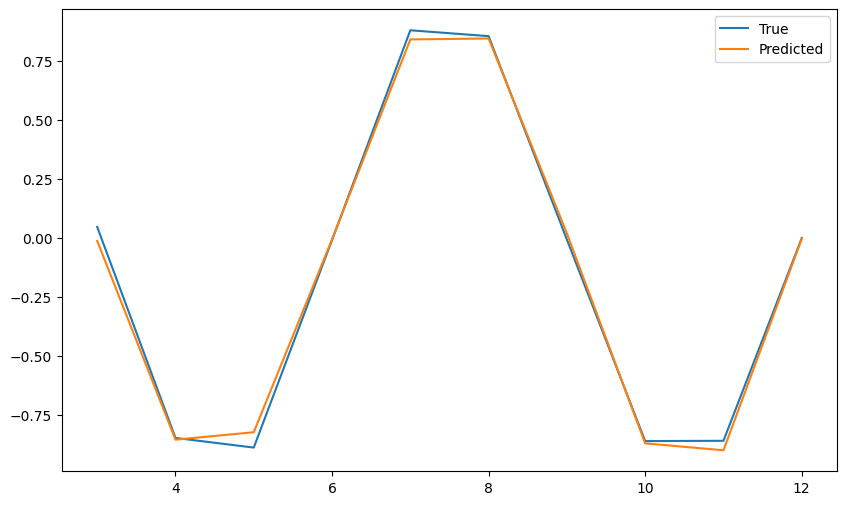

In [6]:
# Make predictions
model.eval()
with torch.no_grad():
    predictions = model(X.unsqueeze(2)).squeeze(2).numpy()

# Plot results
plt.figure(figsize=(10, 6))
out_times = range(forecast_window, seq_length+forecast_window)
plt.plot(out_times, y[3].numpy(), label='True')
plt.plot(out_times, predictions[3], label='Predicted')
plt.legend()
plt.show()

This picture is alright but we shouldn't forget the actual objective of the training: to predict the final `forecast_window` values in the sequence. Below, we compute the L2 error from the RNN model as well as a "naive prediction" where the forecast just extends the input by a constant based on its last value. 

In [7]:
print("RNN prediction error = ", np.linalg.norm(y[3].numpy()[-forecast_window]-predictions[3][-forecast_window]))
print("Naive prediction error = ", np.linalg.norm(y[3].numpy()[-forecast_window]-X[3].numpy()[-1])*np.ones_like(y[3].numpy()[-forecast_window]))

RNN prediction error =  0.009657025
Naive prediction error =  0.86076385


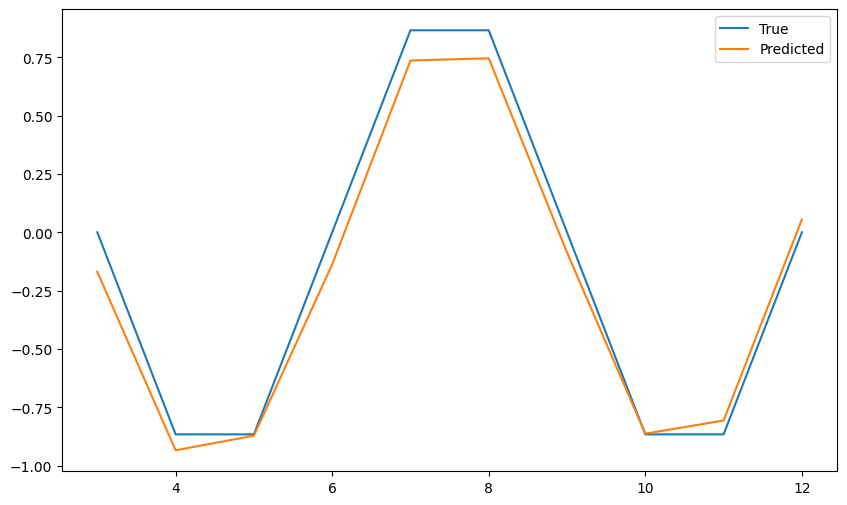

In [10]:
# How does it do outside of the training set? Say an input with more noise? Can it reproduce a perfect sine 
x = np.linspace(0, 2 * np.pi, seq_length + forecast_window)
sine_wave = np.sin(2.*x) 
# very noisy input
X_genl = sine_wave[:-forecast_window] + 0.1*np.random.normal(size=seq_length)
# alter shape bcz the ANN expects it to have a dim for samplesize 
# (along the tensor's first axis)
X_genl = torch.tensor(X_genl, dtype=torch.float32).unsqueeze(0)
X_genl.shape
y_genl = sine_wave[forecast_window:] # desired result: perfect sine
with torch.no_grad():
    pred_genl = model(X_genl.unsqueeze(2)).squeeze(2).numpy()

plt.figure(figsize=(10, 6))
plt.plot(out_times, y_genl, label='True')
plt.plot(out_times, pred_genl[0], label='Predicted')
plt.legend()
plt.show()

In [11]:
print("RNN prediction error = ", np.linalg.norm(y_genl[-forecast_window]-pred_genl[0][-forecast_window]))
print("Naive prediction error = ", np.linalg.norm(y_genl[-forecast_window]-X_genl.numpy()[-1]*np.ones_like(y_genl[-forecast_window])))

RNN prediction error =  0.0028574026095110616
Naive prediction error =  3.9841805


It appears that RNN often beats naive prediction by a solid margin! 